# PREPARACIÓN DEL CÓDIGO DE PRODUCCIÓN

## IMPORTAR LAS LIBRERIAS

Actualizar a las que se usen finalmente en tu proyecto.

In [109]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#Automcompletar rápido
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

## CARGAR LOS DATOS

### Ruta del proyecto

In [2]:
ruta_proyecto = 'C:/Users/pelop/OneDrive/Desktop/Curso Data Science Pedro/2 CURSO DATA SCIENCE/03_MACHINE_LEARNING/07_CASOS/03_RIESGOS'

### Nombre del fichero de datos

In [3]:
nombre_fichero_datos = 'prestamos.csv'

### Cargar los datos

In [4]:
ruta_completa = ruta_proyecto + '/02_Datos/01_Originales/' + nombre_fichero_datos

df = pd.read_csv(ruta_completa,index_col=0)

### Seleccionar solo las variables finales

#### Apuntar (manualmente) la lista de variables finales sin extensiones

In [5]:
variables_finales = ['ingresos_verificados',
                     'vivienda',
                     'finalidad',
                     'num_cuotas',
                     'antigüedad_empleo',
                     'rating',
                     'ingresos',
                     'dti',
                     'num_lineas_credito',
                     'porc_uso_revolving',
                     'principal',
                     'tipo_interes',
                     'imp_cuota',
                     'num_derogatorios',
                     'estado',
                     'imp_amortizado',
                     'imp_recuperado'
                  ]

#### Crear la matriz de variables procesos (excel)

Ir a la plantilla de Excel "Fase Producción Plantilla Procesos" y crear la matriz de variables por procesos.

#### Actualizar las importaciones

Ir arriba a la celda de importacion de paquetes y actualizarlos con los que finalmente vamos a usar.

## ESTRUCTURA DE LOS DATASETS

### Eliminar registros

#### Por atípicos

In [6]:
a_eliminar = df.loc[df.ingresos > 300000].index.values

In [7]:
df = df[~df.index.isin(a_eliminar)]

### Seleccionar variables

Quedarse solo con las de la lista.

In [8]:
df = df[variables_finales]

## CREAR EL PIPELINE

### Instanciar calidad de datos

#### Crear la función

In [9]:
def calidad_datos(temp):
    temp['antigüedad_empleo'] = temp['antigüedad_empleo'].fillna('desconocido')
    temp['dti'].clip(0,100, inplace=True)
    temp['porc_uso_revolving'].clip(0,100, inplace=True)
    
    for column in temp.select_dtypes('number').columns:
        temp[column] = temp[column].fillna(0)
    
    return temp

### Instanciar creación de variables

Dado que la creación de variables es diferente para los 3 modelos necesitamos construir 3 funciones.

#### Crear las funciones

In [11]:
def creacion_variables_pd(df):
    
    temp = df.copy()
    
    temp['target_pd'] = np.where(temp.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
    
    temp.vivienda = temp.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')
    
    temp.finalidad = temp.finalidad.replace(['wedding','educational','renewable_energy'],'other')
    
    #Eliminamos las variables que ya no usaremos
    temp.drop(columns = ['estado','imp_amortizado','imp_recuperado'],inplace = True)
    
    #Separamos entre predictoras y target
    temp_x = temp.iloc[:,:-1]
    temp_y = temp.iloc[:,-1]
    
    return(temp_x,temp_y)

In [12]:
def creacion_variables_ead(df):
    
    temp = df.copy()
    
    temp['pendiente'] = temp.principal - temp.imp_amortizado
    
    temp['target_ead'] = temp.pendiente / temp.principal
    
    temp.vivienda = temp.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')
    
    temp.finalidad = temp.finalidad.replace(['wedding','educational','renewable_energy'],'other')
    
    #Eliminamos las variables que ya no usaremos
    temp.drop(columns = ['estado','imp_amortizado','imp_recuperado','pendiente'],inplace = True)
    
    #Separamos entre predictoras y target
    temp_x = temp.iloc[:,:-1]
    temp_y = temp.iloc[:,-1]
    
    return(temp_x,temp_y)

In [13]:
def creacion_variables_lgd(df):
    
    temp = df.copy()
    
    temp['pendiente'] = temp.principal - temp.imp_amortizado
    
    temp['target_lgd'] = 1 - (temp.imp_recuperado / temp.pendiente)
    
    temp['target_lgd'].fillna(0,inplace=True)
    
    temp.vivienda = temp.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')
    
    temp.finalidad = temp.finalidad.replace(['wedding','educational','renewable_energy'],'other')
    
    #Eliminamos las variables que ya no usaremos
    temp.drop(columns = ['estado','imp_amortizado','imp_recuperado','pendiente'],inplace = True)
    
    #Separamos entre predictoras y target
    temp_x = temp.iloc[:,:-1]
    temp_y = temp.iloc[:,-1]
    
    return(temp_x,temp_y)

#### Crear los dataframes de X e y

In [14]:
x_pd, y_pd = creacion_variables_pd(calidad_datos(df))

x_ead, y_ead = creacion_variables_ead(calidad_datos(df))

x_lgd, y_lgd = creacion_variables_lgd(calidad_datos(df))

### Instanciar transformación de variables

In [20]:
#ONE HOT ENCODING
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']
ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore')


#ORDINAL ENCODING
var_oe = ['antigüedad_empleo','rating']

orden_antigüedad_empleo = ['10+ years','9 years','8 years','7 years','6 years','5 years',
                           '4 years','3 years','2 years','1 year','< 1 year','desconocido']

orden_rating = ['A','B','C','D','E','F','G']

oe = OrdinalEncoder(categories = [orden_antigüedad_empleo,orden_rating],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#BINNING
var_bin = ['num_derogatorios']
bina = Binarizer(threshold=0)


#MIN-MAX SCALING
mms = MinMaxScaler()


### Crear el pipe del preprocesamiento

#### Crear el column transformer

In [21]:
ct = make_column_transformer(
    (ohe, var_ohe),
    (oe, var_oe),
    (bina, var_bin),
    remainder='passthrough')

#### Crear el pipeline de preprocesamiento

In [22]:
pipe_prepo = make_pipeline(ct, mms)

### Instanciar los modelos

#### Instanciar los algoritmos

In [29]:
modelo_pd = LogisticRegression(solver = 'saga', n_jobs=-1, C = 1, penalty = 'l1')

modelo_ead = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 10,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_percentage_error',
                                          l2_regularization = 1)

modelo_lgd = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 20,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_percentage_error',
                                          l2_regularization = 0.25)

#### Crear los pipes finales de entrenamiento

In [30]:
pipe_entrenamiento_pd = make_pipeline(pipe_prepo,modelo_pd)

pipe_entrenamiento_ead = make_pipeline(pipe_prepo,modelo_ead)

pipe_entrenamiento_lgd = make_pipeline(pipe_prepo,modelo_lgd)

#### Guardar el pipe final de entrenamiento

In [31]:
ruta_pipe_entrenamiento_pd = ruta_proyecto + '/04_Modelos/pipe_entrenamiento_pd.pickle'

with open(ruta_pipe_entrenamiento_pd, mode='wb') as file:
   pickle.dump(pipe_entrenamiento_pd, file)

In [32]:
ruta_pipe_entrenamiento_ead = ruta_proyecto + '/04_Modelos/pipe_entrenamiento_ead.pickle'

with open(ruta_pipe_entrenamiento_ead, mode='wb') as file:
   pickle.dump(pipe_entrenamiento_ead, file)

In [33]:
ruta_pipe_entrenamiento_lgd = ruta_proyecto + '/04_Modelos/pipe_entrenamiento_lgd.pickle'

with open(ruta_pipe_entrenamiento_lgd, mode='wb') as file:
   pickle.dump(pipe_entrenamiento_lgd, file)

#### Entrenar los pipes

In [34]:
pipe_ejecucion_pd = pipe_entrenamiento_pd.fit(x_pd,y_pd)
pipe_ejecucion_ead = pipe_entrenamiento_ead.fit(x_ead,y_ead)
pipe_ejecucion_lgd = pipe_entrenamiento_lgd.fit(x_lgd,y_lgd)

## GUARDAR EL PIPE

### Guardar el pipe final de ejecución

In [35]:
ruta_pipe_ejecucion_pd = ruta_proyecto + '/04_Modelos/pipe_ejecucion_pd.pickle'

with open(ruta_pipe_ejecucion_pd, mode='wb') as file:
   pickle.dump(pipe_ejecucion_pd, file)

In [36]:
ruta_pipe_ejecucion_ead = ruta_proyecto + '/04_Modelos/pipe_ejecucion_ead.pickle'

with open(ruta_pipe_ejecucion_ead, mode='wb') as file:
   pickle.dump(pipe_ejecucion_ead, file)

In [37]:
ruta_pipe_ejecucion_lgd = ruta_proyecto + '/04_Modelos/pipe_ejecucion_lgd.pickle'

with open(ruta_pipe_ejecucion_lgd, mode='wb') as file:
   pickle.dump(pipe_ejecucion_lgd, file)

# EVALUACIÓN DEL MODELO FINAL

Cargamos dataset de validación.

In [169]:
nombre_fichero_datos = 'validacion.csv'
ruta_completa = ruta_proyecto + '/02_Datos/02_Validacion/' + nombre_fichero_datos
df_eval = pd.read_csv(ruta_completa,index_col='id_cliente').drop(columns='Unnamed: 0')

Aplicamos las transformaciones correspondientes:

In [170]:
a_eliminar = df_eval.loc[df_eval.ingresos > 300000].index.values
df_eval = df_eval[~df_eval.index.isin(a_eliminar)]
df_eval = df_eval[variables_finales]

In [171]:
# CALIDAD Y CREACION DE VARIABLES
x_eval_pd, y_eval_pd = creacion_variables_pd(calidad_datos(df_eval))
x_eval_ead, y_eval_ead = creacion_variables_ead(calidad_datos(df_eval))
x_eval_lgd, y_eval_lgd = creacion_variables_lgd(calidad_datos(df_eval))

In [172]:
# EJECUCIÓN
scoring_pd = pipe_ejecucion_pd.predict_proba(x_eval_pd)[:, 1]
ead = pipe_ejecucion_ead.predict(x_eval_ead)
lgd = pipe_ejecucion_lgd.predict(x_eval_lgd)

# RESULTADO
principal = x_eval_pd.principal
EL = pd.DataFrame({'principal':principal,
                   'pd':scoring_pd,
                   'ead':ead,
                   'lgd':lgd                   
                   })
EL['EL_model'] = round(EL.pd * EL.principal * EL.ead * EL.lgd,2)
EL['EL_real'] = round(y_eval_pd * EL.principal * y_eval_ead * y_eval_lgd,2)
EL.EL_real.fillna(0, inplace = True)

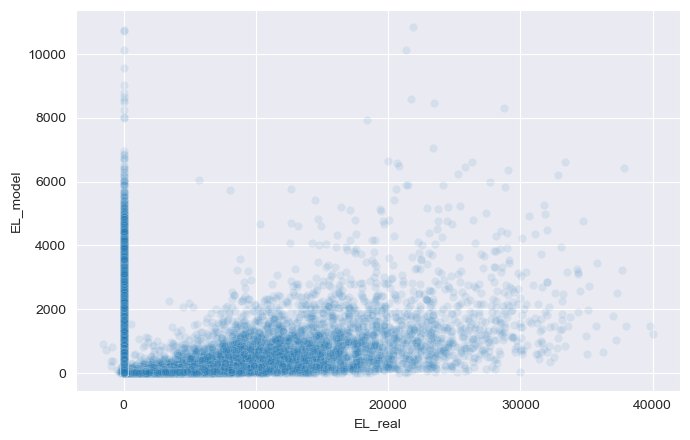

In [189]:
plt.figure(figsize = (7,4.5))
sns.scatterplot(data = EL, x = 'EL_real', y = 'EL_model', alpha = 0.1);
#plt.axis('equal');
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('exhibit_10.png')

In [192]:
pd.concat([EL,y_eval_pd,y_eval_ead,y_eval_lgd],axis = 1)

,principal,pd,ead,lgd,EL_model,EL_real,target_pd,target_ead,target_lgd
id_cliente,,,,,,,,,
6523777,24600.0,0.076405,0.047435,0.077318,6.89,0.00,0,0.000000,0.0
127564341,35000.0,0.087812,0.453583,0.619178,863.17,0.00,0,0.841877,1.0
85751427,20000.0,0.038254,0.122111,0.291714,27.25,0.00,0,0.125611,1.0
50183160,9600.0,0.084502,0.114751,0.235877,21.96,0.00,0,0.000000,0.0
81468644,7200.0,0.108671,0.083710,0.276747,18.13,0.00,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
145245827,20000.0,0.099656,0.868253,0.849327,1469.78,0.00,0,0.968140,1.0
12796419,14675.0,0.225514,0.395890,0.641923,841.02,7426.32,1,0.506052,1.0
96319652,17000.0,0.047591,0.215410,0.408892,71.26,0.00,0,0.000000,0.0
